# Hakwes Process w/ tensorflow

See [`arxiv:1507.02822`](https://arxiv.org/pdf/1507.02822.pdf).

The conditional intensity function is parametrized as: $\mu(t) = \mu_0 + \alpha \sum_{t_i < t} e^{-\beta(t - t_i)}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm

In [3]:
def simulate(mu0, alpha, beta, tmax):
    """Simulate the Hawkes process by thinning."""
    epsilon = 1e-6
    
    events = [np.random.exponential(1.0 / mu0)]
    
    # TODO: reuse the sum when simulating
    while events[-1] < tmax:
        bound = intensity(mu0, alpha, beta, events, events[-1] + epsilon)
        tnew = events[-1] + np.random.exponential(1.0 / bound)
        u = np.random.uniform(0.0, bound)
        mu = intensity(mu0, alpha, beta, events, tnew)
        
        if u < mu and tnew > tmax:
            break
            
        elif u < mu:
            events += [tnew]
        
    return np.asarray(events)
        
    
def intensity(mu0, alpha, beta, events, t):
    events = np.asarray(events).reshape(-1)
    t = np.asarray(t).reshape(-1)
    delta = t[:, None] - events[None, :]
    return mu0 + alpha * np.sum((delta > 0) * np.exp(-beta * delta), axis=1)

In [4]:
mu0 = 10
alpha = 0.5
beta = 2

traces = [
    simulate(mu0, alpha, beta, 40)
    for _ in range(100)
]

In [5]:
min_len = min(len(t) for t in traces)
max_len = max(len(t) for t in traces)
#traces = [t[:min_len] for t in traces]

In [6]:
padded = np.zeros((len(traces), max_len), dtype=np.float32)
masks = np.ones((len(traces), max_len), dtype=np.float32)

for idx, t in enumerate(traces):
    padded[idx, :len(t)] = t
    masks[idx, len(t):] = 0

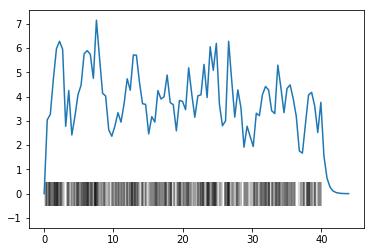

In [7]:
time = np.linspace(0, 1.1 * traces[0].max(), 100)

plt.eventplot(traces[0], lineoffsets=0, color='k', alpha=0.2)
plt.plot(time, intensity(mu0, alpha, beta, traces[0], time) - mu0)

## tensorflow 

In [8]:
def unpacked(f):
    return lambda *ps: f(*[i for p in ps for i in p])

In [9]:
tf.reset_default_graph()

events_ = tf.placeholder(tf.float32, shape=[None, None])
mask_ = tf.placeholder(tf.float32, shape=[None, None])

mu0_ = tf.Variable(np.random.uniform(0.5, 10.0), dtype=tf.float32)
mu0_ = tf.nn.softplus(mu0_)

alpha_ = tf.Variable(0.0, dtype=tf.float32)
alpha_ = tf.nn.softplus(alpha_)

beta_ = tf.Variable(np.random.uniform(1.0, 10.0), dtype=tf.float32)
beta_ = tf.nn.softplus(beta_)

# build loglikelihood
tmax_ = tf.reduce_max(mask_ * events_, axis=1)

# Notes:
# use initial value prev_a to ensure A(0) = 0
# prevent overflows in scan, due to 0 in padding
scan_events_ = mask_ * events_ + (1.0 - mask_) * tf.expand_dims(tmax_, axis=1)
a_, _ = tf.scan(
    unpacked(lambda prev_a, prev_event, current_event: [
        tf.exp(-beta_ * (current_event - prev_event)) * (1 + prev_a),
        current_event,
    ]),
    [tf.transpose(scan_events_)],
    [-tf.ones_like(tmax_), tf.zeros_like(tmax_)],
)

a_ = tf.transpose(a_)

ll_ = tf.reduce_mean(
    tf.reduce_sum(mask_ * tf.log(mu0_ + alpha_ * a_), axis=1) +
    -mu0_ * tmax_ +
    alpha_ / beta_ * tf.reduce_sum(mask_ * (tf.exp(-beta_ * (tf.expand_dims(tmax_, axis=1) - events_)) - 1), axis=1)
)

optimizer_ = tf.train.RMSPropOptimizer(0.1)
train_ = optimizer_.minimize(-ll_)

In [10]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    optimizer_ = tf.contrib.opt.ScipyOptimizerInterface(-ll_)
    optimizer_.minimize(sess, {events_: padded, mask_: masks})
    
    lbfgs_params = sess.run([mu0_, alpha_, beta_])
    lbfgs_params = dict(zip(['mu0', 'alpha', 'beta'], lbfgs_params))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -977.540161
  Number of iterations: 18
  Number of functions evaluations: 38
CPU times: user 23.8 s, sys: 17.9 s, total: 41.7 s
Wall time: 21 s


In [11]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    status = tqdm(range(101))
    for idx in status:
        _, ll = sess.run([train_, ll_], {events_: padded, mask_: masks})
        
        rmsp_params = sess.run([mu0_, alpha_, beta_])
        rmsp_params = dict(zip(['mu0', 'alpha', 'beta'], rmsp_params))
        
        if idx % 50 == 0:
            status.write('ll: {ll} mu0: {mu0:.1f} alpha: {alpha:.1f} beta: {beta:.1f}'.format(ll=ll, **rmsp_params))

ll: 928.3585815429688 mu0: 3.0 alpha: 0.9 beta: 1.2
ll: 974.2868041992188 mu0: 5.5 alpha: 0.7 beta: 1.1
ll: 976.4176025390625 mu0: 7.7 alpha: 0.6 beta: 1.2

CPU times: user 1min 13s, sys: 1min 11s, total: 2min 24s
Wall time: 1min 11s


# Mixture of Poisson Point Processes

$$
\begin{align}
    P(N) &= \frac{\Lambda^N}{N!}e^{-\Lambda} 
\\
    P(t_i) &= \frac{\lambda(t_i)}{\Lambda}
\end{align}
$$

$$
\begin{align}
    \lambda_1(t) &= \lambda_1  \\
    \lambda_2(t) &= \gamma \lambda_2 e^{-\gamma t / T}
\end{align}
$$

$$
\begin{align}
    \Lambda_1 &= \lambda_1 T \\
    \Lambda_2 &= \lambda_2 T (1 - e^{-\gamma T}) \approx \lambda_2 T
\end{align}
$$

$$
    \log L = \sum_i z_{i,1} \log \lambda_1(t_i) + \sum_i z_{i,2} \log \lambda_2(t_1) - \lambda_1 T - \lambda_2 T
$$

$$
\begin{align}
    \frac{\partial}{\partial \lambda_1} \log L = \sum_i z_{i,1} \frac{1}{\lambda_1} - T
\\
    \frac{\partial}{\partial \lambda_2} \log L = \sum_i z_{i,2} \frac{1}{\lambda_2} - T
\\
    \frac{\partial}{\partial \gamma} \log L = \sum_i z_{i,2} \frac{1}{\gamma} - \sum_i z_{i,2} \frac{t_i}{T}
\end{align}
$$

$$
\begin{align}
     \lambda_1 &= \frac{\sum_i z_{i,1}}{T}
\\
     \lambda_2 &= \frac{\sum_i z_{i,2}}{T}
\\
    \gamma &= \frac{\sum_i z_{i,2} T}{\sum_i z_{i,2} t_i}
\end{align}
$$

$$
\begin{align}
    z_{i,1} = \frac{\lambda_1(t_i)}{\lambda_1(t_i) + \lambda_2(t_i)}
\\
    z_{i,2} = \frac{\lambda_2(t_i)}{\lambda_1(t_i) + \lambda_2(t_i)}
\end{align}
$$